In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
pd.set_option('display.max_columns', None)


In [2]:
eqtl = pd.read_csv("./processed_data/eqtl_gtex_susie.csv.gz")
multiome = pd.read_csv("./processed_data/multiome_pgb.csv.gz")
eqtl.head(), multiome.head()

(         region   chr      start             gene  pli       cts      dist  \
 0   chr1:632834  chr1   632834.0  ENSG00000235098  0.0  7.137414  788426.0   
 1   chr1:898547  chr1   898547.0  ENSG00000235098  0.0  7.137414  522713.0   
 2   chr1:946870  chr1   946870.0  ENSG00000188976  0.0  5.027266   12439.0   
 3   chr1:975014  chr1   975014.0  ENSG00000187583  0.0  4.484527   -1502.0   
 4  chr1:1016965  chr1  1016965.0  ENSG00000235098  0.0  7.137414  404295.0   
 
    pip                    tissue  eqtl  cumulative_pip  credible_set  \
 0  1.0          Brain_Cerebellum     1             1.0             1   
 1  1.0  Brain_Frontal_Cortex_BA9     1             1.0             1   
 2  1.0           Muscle_Skeletal     1             1.0             1   
 3  1.0           Muscle_Skeletal     1             1.0             1   
 4  1.0      Esophagus_Muscularis     1             1.0             1   
 
    multiome  multiome_finemap  gwas  pops_priority  
 0         0                 0

In [5]:
(eqtl["pip"] > 0.1).sum(), (multiome["SCENT"] < 0.1).sum()

(900530, 60946)

In [34]:
eqtl[(eqtl["pip"] > 0.1) & (eqtl["cts"] > 10)].drop_duplicates(["region","gene"]).shape, eqtl[(eqtl["pip"] > 0.1) & (eqtl["cts"] <= 10)].drop_duplicates(["region","gene"]).shape

((91922, 16), (172987, 16))

In [39]:
multiome[(multiome["SCENT"] < 0.1) & (multiome["cts"] > 10)].drop_duplicates(["region","gene"]).shape, multiome[(multiome["SCENT"] < 0.1) & (multiome["cts"] <= 10)].drop_duplicates(["region","gene"]).shape

((40385, 14), (20561, 14))

In [37]:
multiome[(multiome["SCENT"] < 0.1) & (multiome["pli"] > 0.9)].drop_duplicates(["region","gene"]).shape, multiome[(multiome["SCENT"] < 0.1) & (multiome["pli"] <= 0.9)].drop_duplicates(["region","gene"]).shape

((14514, 14), (46432, 14))

In [40]:
eqtl[(eqtl["pip"] > 0.1) & (eqtl["pli"] > 0.9)].drop_duplicates(["region","gene"]).shape, eqtl[(eqtl["pip"] > 0.1) & (eqtl["pli"] <= 0.9)].drop_duplicates(["region","gene"]).shape

((29500, 16), (235409, 16))

In [85]:
intersection = multiome.merge(eqtl, how="inner", on=["chr", "start", "gene"])
intersection_cleaned = intersection.drop_duplicates(subset=["chr", "start", "gene", "tissue"])
intersection.shape, intersection_cleaned.shape

((16882, 27), (12678, 27))

In [91]:
intersection_cleaned = intersection.drop_duplicates(subset=["chr", "start", "gene", "tissue"]).copy()
intersection_cleaned["eqtl_pass"] = intersection_cleaned["pip"] >= 0.1
intersection_cleaned["scent_pass"] = intersection_cleaned["SCENT"] <= 0.1


In [92]:
intersection_cleaned[intersection_cleaned["cts_y"] >10].value_counts(["eqtl_pass", "scent_pass"])

eqtl_pass  scent_pass
False      False         4267
True       False          286
False      True            85
True       True             5
Name: count, dtype: int64

In [93]:
intersection_cleaned[intersection_cleaned["cts_y"] <=10].value_counts(["eqtl_pass", "scent_pass"])

eqtl_pass  scent_pass
False      False         7542
True       False          380
False      True            97
True       True            16
Name: count, dtype: int64

In [94]:
intersection_cleaned[intersection_cleaned["pli_y"] >0.9].value_counts(["eqtl_pass", "scent_pass"])

eqtl_pass  scent_pass
False      False         1229
True       False           43
False      True            38
True       True             1
Name: count, dtype: int64

In [95]:
intersection_cleaned[intersection_cleaned["pli_y"] <= 0.9].value_counts(["eqtl_pass", "scent_pass"])

eqtl_pass  scent_pass
False      False         10580
True       False           623
False      True            144
True       True             20
Name: count, dtype: int64

In [6]:
crispr = pd.read_csv("./processed_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz", sep="\t")
crispr.head()

,dataset,chrom,chromStart,chromEnd,name,EffectSize,chrTSS,startTSS,endTSS,measuredGeneSymbol,Significant,pValueAdjusted,PowerAtEffectSize25,ValidConnection,CellType,Reference,Regulated,PowerAtEffectSize10,PowerAtEffectSize15,PowerAtEffectSize20,PowerAtEffectSize50,pair_uid,merged_uid,merged_start,merged_end
0,FlowFISH_K562,chr1,3774714,3775214,CEP104|chr1:3691278-3691778:*,-0.293432,chr1,3857213.0,3857214.0,CEP104,True,0.004024,0.825094,True,K562,Ulirsch2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|CEP104|chr1:3691278-3691778:*,1,3774714,3775214
1,FlowFISH_K562,chr1,3774714,3775214,LRRC47|chr1:3691278-3691778:*,-0.331178,chr1,3796503.0,3796504.0,LRRC47,True,0.007771,0.608994,True,K562,Ulirsch2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|LRRC47|chr1:3691278-3691778:*,2,3774714,3775214
2,Gasperini2019,chr1,3803570,3805848,LRRC47|chr1:3720134-3722412:.,-0.001471,chr1,3796503.0,3796504.0,LRRC47,False,0.999918,1.000000,True,K562,"Gasperini et al., 2019",False,0.4,0.80,0.85,1.0,Gasperini2019|LRRC47|chr1:3720134-3722412:.,3,3803570,3805848
3,FlowFISH_K562,chr1,3774714,3775214,SMIM1|chr1:3691278-3691778:*,-0.472019,chr1,3772761.0,3772762.0,SMIM1,True,0.000642,0.639332,True,K562,Ulirsch2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|SMIM1|chr1:3691278-3691778:*,4,3774714,3775214
4,Gasperini2019,chr1,3803570,3805848,SMIM1|chr1:3720134-3722412:.,0.025677,chr1,3772788.0,3772789.0,SMIM1,False,0.994160,1.000000,True,K562,"Gasperini et al., 2019",False,0.8,0.85,1.00,1.0,Gasperini2019|SMIM1|chr1:3720134-3722412:.,5,3803570,3805848


In [27]:
def helper(l):
    for elem in l:
        if elem.startswith("Ensembl"):
            return elem.split(":")[1]
    return ""

gene_info = pd.read_csv("../perez_eqtl/Homo_sapiens.gene_info", sep="\t")
gene_info["refs"] = gene_info["dbXrefs"].str.split("|")
gene_info["gene"] = gene_info["refs"].apply(helper)
gene_info1 = gene_info[gene_info["gene"]!= ""][["Symbol", "gene"]]
df = crispr.merge(gene_info1, how="left", left_on="measuredGeneSymbol", right_on="Symbol")#.drop(columns=["Symbol", "STD_FE"])
df["gene"] = df["gene"].fillna(df["measuredGeneSymbol"])
df["chromStart"] = df["chromStart"].astype(int)
df["chromEnd"] = df["chromEnd"].astype(int)
df

,dataset,chrom,chromStart,chromEnd,name,EffectSize,chrTSS,startTSS,endTSS,measuredGeneSymbol,Significant,pValueAdjusted,PowerAtEffectSize25,ValidConnection,CellType,Reference,Regulated,PowerAtEffectSize10,PowerAtEffectSize15,PowerAtEffectSize20,PowerAtEffectSize50,pair_uid,merged_uid,merged_start,merged_end,Symbol,gene
0,FlowFISH_K562,chr1,3774714,3775214,CEP104|chr1:3691278-3691778:*,-0.293432,chr1,3857213.0,3857214.0,CEP104,True,0.004024,0.825094,True,K562,Ulirsch2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|CEP104|chr1:3691278-3691778:*,1,3774714,3775214,CEP104,ENSG00000116198
1,FlowFISH_K562,chr1,3774714,3775214,LRRC47|chr1:3691278-3691778:*,-0.331178,chr1,3796503.0,3796504.0,LRRC47,True,0.007771,0.608994,True,K562,Ulirsch2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|LRRC47|chr1:3691278-3691778:*,2,3774714,3775214,LRRC47,ENSG00000130764
2,Gasperini2019,chr1,3803570,3805848,LRRC47|chr1:3720134-3722412:.,-0.001471,chr1,3796503.0,3796504.0,LRRC47,False,0.999918,1.000000,True,K562,"Gasperini et al., 2019",False,0.40,0.80,0.85,1.0,Gasperini2019|LRRC47|chr1:3720134-3722412:.,3,3803570,3805848,LRRC47,ENSG00000130764
3,FlowFISH_K562,chr1,3774714,3775214,SMIM1|chr1:3691278-3691778:*,-0.472019,chr1,3772761.0,3772762.0,SMIM1,True,0.000642,0.639332,True,K562,Ulirsch2016,True,NaN,NaN,NaN,NaN,FlowFISH_K562|SMIM1|chr1:3691278-3691778:*,4,3774714,3775214,SMIM1,ENSG00000235169
4,Gasperini2019,chr1,3803570,3805848,SMIM1|chr1:3720134-3722412:.,0.025677,chr1,3772788.0,3772789.0,SMIM1,False,0.994160,1.000000,True,K562,"Gasperini et al., 2019",False,0.80,0.85,1.00,1.0,Gasperini2019|SMIM1|chr1:3720134-3722412:.,5,3803570,3805848,SMIM1,ENSG00000235169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10407,Gasperini2019,chrX,155434755,155435408,LAGE3|chrX:154664416-154665069:.,0.012127,chrX,154479256.0,154479257.0,LAGE3,False,0.999918,1.000000,True,K562,"Gasperini et al., 2019",False,0.75,0.85,0.95,1.0,Gasperini2019|LAGE3|chrX:154664416-154665069:.,10408,155434755,155435408,LAGE3,ENSG00000196976
10408,Gasperini2019,chrX,154527069,154527569,UBL4A|chrX:153755283-153755783:.,-0.006651,chrX,154486669.0,154486670.0,UBL4A,False,0.999918,0.950000,True,K562,"Gasperini et al., 2019",False,0.50,0.80,0.85,1.0,Gasperini2019|UBL4A|chrX:153755283-153755783:.,10409,154527069,154527569,UBL4A,ENSG00000102178
10409,Gasperini2019,chrX,155434755,155435408,UBL4A|chrX:154664416-154665069:.,0.003708,chrX,154486669.0,154486670.0,UBL4A,False,0.999918,0.950000,True,K562,"Gasperini et al., 2019",False,0.70,0.85,0.95,1.0,Gasperini2019|UBL4A|chrX:154664416-154665069:.,10410,155434755,155435408,UBL4A,ENSG00000102178
10410,Gasperini2019,chrX,155434755,155435408,DKC1|chrX:154664416-154665069:.,0.009955,chrX,154762742.0,154762743.0,DKC1,False,0.999918,0.950000,True,K562,"Gasperini et al., 2019",False,0.45,0.80,0.95,1.0,Gasperini2019|DKC1|chrX:154664416-154665069:.,10411,155434755,155435408,DKC1,ENSG00000130826


In [28]:
df = df.merge(
    pd.concat([
        multiome[["gene", "pli"]].drop_duplicates(),
        eqtl[["gene", "pli"]].drop_duplicates(),
    ]), 
    how="left", on="gene"
).merge(
    pd.concat([
        multiome[["gene", "cts"]].drop_duplicates(),
        eqtl[["gene", "cts"]].drop_duplicates(),
    ]), 
    how="left", on="gene"
).fillna(0)

In [29]:
df1 = df.copy()
df1["logfc10"] = df1["cts"] > 10
df1["pli0.9"] = df1["pli"] > 0.9
print(df1.value_counts(["Significant", "logfc10"]))
print(df1.value_counts(["Significant", "pli0.9"]))

Significant  logfc10
False        True       20924
             False       8434
True         True        1080
             False        599
Name: count, dtype: int64
Significant  pli0.9
False        False     23023
             True       6335
True         False      1315
             True        364
Name: count, dtype: int64


In [30]:
df1.groupby(["logfc10"])["Significant"].sum(), df1.groupby(["pli0.9"])["Significant"].sum()

(logfc10
 False     599
 True     1080
 Name: Significant, dtype: int64,
 pli0.9
 False    1315
 True      364
 Name: Significant, dtype: int64)

In [25]:
eqtl[["gene", "cts"]].drop_duplicates().sort_values(by="gene")

,gene,cts
13610,ENSG00000000003,13.625408
78053,ENSG00000000005,10.010907
92251,ENSG00000000457,4.871694
89358,ENSG00000000460,5.087788
67698,ENSG00000000938,26.217619
...,...,...
121532,ENSG00000272325,2.853021
114800,ENSG00000272514,6.268838
36204,ENSG00000272573,5.081792
22042,ENSG00000273079,7.076047


In [26]:
dfs = []
print(len(df[df["chrom"]=="chr19"]))
for _, row in tqdm(df[df["chrom"]=="chr19"].iterrows()):
    subdf = multiome[
        (multiome["chr"] == "chr19") & 
        (multiome["gene"] == row["gene"]) & 
        (multiome["start"] >= row["chromStart"]) & 
        (multiome["start"] <= row["chromEnd"])
    ].copy()
    if len(subdf) > 0: 
        subdf["chromStart"] = row["chromStart"]
        subdf["chromEnd"] = row["chromEnd"]
        subdf["Significant"] = row["Significant"]
        dfs.append(subdf)
    # print(row, row["chrom"])
    # break
crispr_multiome = pd.concat(dfs)
print(crispr_multiome.shape)
crispr_multiome.head()

2266


0it [00:00, ?it/s]

(2003, 17)


,region,chr,start,gene,pli,cts,dist,SCENT,multiome,multiome_finemap,gwas,pops_priority,eqtl,credible_set,chromStart,chromEnd,Significant
2137267,chr19:555832-555833,chr19,555832.0,ENSG00000172270,0.0,18.768976,24814.0,0.474816,1,0,0,0,0,0,555793,556394,True
2137293,chr19:555838-555839,chr19,555838.0,ENSG00000172270,0.0,18.768976,24808.0,0.474816,1,0,0,0,0,0,555793,556394,True
2137456,chr19:556111-556112,chr19,556111.0,ENSG00000172270,0.0,18.768976,24535.0,0.474816,1,0,0,0,0,0,555793,556394,True
2137759,chr19:556307-556308,chr19,556307.0,ENSG00000172270,0.0,18.768976,24339.0,0.474816,1,0,0,0,0,0,555793,556394,True
2198016,chr19:982697-982698,chr19,982697.0,ENSG00000172270,0.0,18.768976,-402051.0,0.762557,1,0,0,0,0,0,982611,983111,False


In [27]:
dfs = []
print(len(df[df["chrom"]=="chr19"]))
for _, row in tqdm(df[df["chrom"]=="chr19"].iterrows()):
    subdf = eqtl[
        (eqtl["chr"] == "chr19") & 
        (eqtl["gene"] == row["gene"]) & 
        (eqtl["start"] >= row["chromStart"]) & 
        (eqtl["start"] <= row["chromEnd"])
    ].copy()
    if len(subdf) > 0: 
        subdf["chromStart"] = row["chromStart"]
        subdf["chromEnd"] = row["chromEnd"]
        subdf["Significant"] = row["Significant"]
        dfs.append(subdf)
    # print(row, row["chrom"])
    # break
crispr_eqtl = pd.concat(dfs)
print(crispr_eqtl.shape)
crispr_eqtl.head()

2266


0it [00:00, ?it/s]

(761, 19)


,region,chr,start,gene,pli,cts,dist,pip,tissue,eqtl,cumulative_pip,credible_set,multiome,multiome_finemap,gwas,pops_priority,chromStart,chromEnd,Significant
13860272,chr19:555839,chr19,555839.0,ENSG00000172270,0.0,18.768976,24808.0,0.001245,Colon_Sigmoid,1,4.957516,0,0,0,0,0,555793,556394,True
19203505,chr19:555833,chr19,555833.0,ENSG00000172270,0.0,18.768976,24814.0,0.000171,Skin_Not_Sun_Exposed_Suprapubic,1,3.422107,0,0,0,0,0,555793,556394,True
21957570,chr19:555833,chr19,555833.0,ENSG00000172270,0.0,18.768976,24814.0,0.000105,Whole_Blood,1,2.739544,0,0,0,0,0,555793,556394,True
12282660,chr19:982793,chr19,982793.0,ENSG00000172270,0.0,18.768976,-402146.0,0.002806,Colon_Sigmoid,1,4.942069,0,0,0,0,0,982611,983111,False
17464171,chr19:1101922,chr19,1101922.0,ENSG00000172270,0.0,18.768976,-521275.0,0.000265,Whole_Blood,1,2.697284,0,0,0,0,0,1101709,1102209,False


## Option 1: CRISPRi

In [57]:
# crispr_eqtl1 = crispr_eqtl.sort_values(by="pip", ascending=False).drop_duplicates(subset=["region", "gene", "Significant"])

<Axes: >

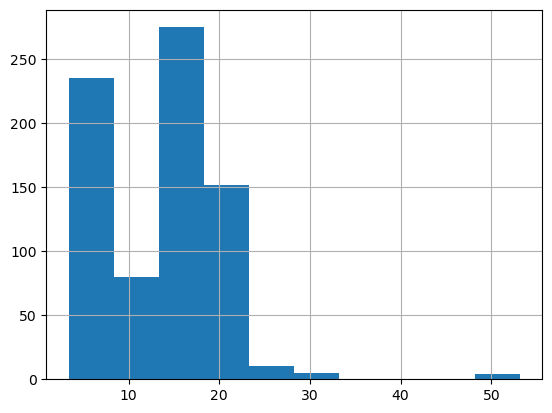

In [58]:
crispr_eqtl["cts"].hist()

<Axes: >

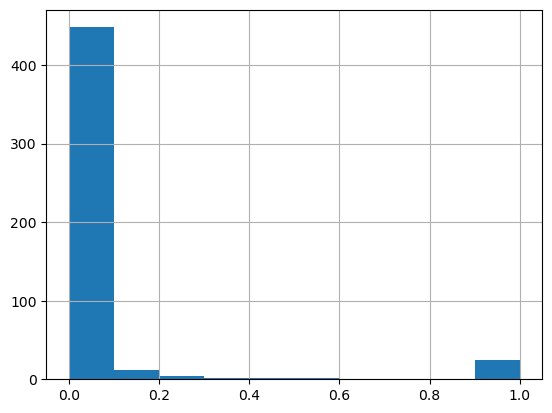

In [60]:
crispr_eqtl[crispr_eqtl["cts"] >= 10]["pip"].hist()

<Axes: >

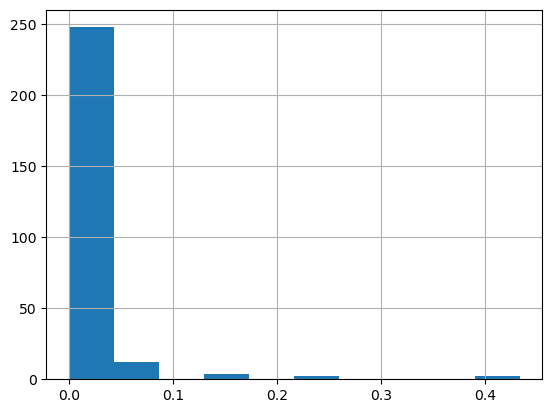

In [61]:
crispr_eqtl[crispr_eqtl["cts"] < 10]["pip"].hist()

In [62]:
# crispr_eqtl1[crispr_eqtl1["cts"] >= 10]["Significant"].sum(), crispr_eqtl1[crispr_eqtl1["cts"] <= 10]["Significant"].sum()

In [97]:
crispr_eqtl["eqtl_pass"] = crispr_eqtl["pip"] >= 0.1

In [74]:
crispr_eqtl[crispr_eqtl["cts"] > 10].value_counts(["eqtl_pass", "Significant"])

eqtl_pass  Significant
False      False          421
True       False           44
False      True            27
True       True             1
Name: count, dtype: int64

In [98]:
crispr_eqtl[crispr_eqtl["pli"] > 0.9].value_counts(["eqtl_pass", "Significant"])

eqtl_pass  Significant
False      False          30
Name: count, dtype: int64

In [99]:
crispr_eqtl[crispr_eqtl["pli"] <= 0.9].value_counts(["eqtl_pass", "Significant"])

eqtl_pass  Significant
False      False          641
True       False           51
False      True            37
True       True             2
Name: count, dtype: int64

In [102]:
crispr_multiome[crispr_multiome["pli"] > 0.9].value_counts(["scent_pass", "Significant"])

scent_pass  Significant
False       False          144
True        False           23
False       True             8
Name: count, dtype: int64

In [104]:
crispr_multiome[crispr_multiome["pli"] <= 0.9].value_counts(["scent_pass", "Significant"])

scent_pass  Significant
False       False          1706
True        False            80
False       True             31
True        True             11
Name: count, dtype: int64

In [75]:
crispr_eqtl[crispr_eqtl["cts"] <= 10].value_counts(["eqtl_pass", "Significant"])

eqtl_pass  Significant
False      False          250
           True            10
True       False            7
           True             1
Name: count, dtype: int64

In [76]:
crispr_multiome["scent_pass"] = crispr_multiome["SCENT"] <= 0.1
crispr_multiome[crispr_multiome["cts"] > 10].value_counts(["scent_pass", "Significant"])

scent_pass  Significant
False       False          1195
True        False            95
False       True             29
True        True             11
Name: count, dtype: int64

In [77]:
crispr_multiome[crispr_multiome["cts"] <= 10].value_counts(["scent_pass", "Significant"])

scent_pass  Significant
False       False          655
            True            10
True        False            8
Name: count, dtype: int64

In [78]:
crispr_multiome

,region,chr,start,gene,pli,cts,dist,SCENT,multiome,multiome_finemap,gwas,pops_priority,eqtl,credible_set,chromStart,chromEnd,Significant,scent_pass
2137267,chr19:555832-555833,chr19,555832.0,ENSG00000172270,0.00,18.768976,24814.0,0.474816,1,0,0,0,0,0,555793,556394,True,False
2137293,chr19:555838-555839,chr19,555838.0,ENSG00000172270,0.00,18.768976,24808.0,0.474816,1,0,0,0,0,0,555793,556394,True,False
2137456,chr19:556111-556112,chr19,556111.0,ENSG00000172270,0.00,18.768976,24535.0,0.474816,1,0,0,0,0,0,555793,556394,True,False
2137759,chr19:556307-556308,chr19,556307.0,ENSG00000172270,0.00,18.768976,24339.0,0.474816,1,0,0,0,0,0,555793,556394,True,False
2198016,chr19:982697-982698,chr19,982697.0,ENSG00000172270,0.00,18.768976,-402051.0,0.762557,1,0,0,0,0,0,982611,983111,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136633,chr19:55547370-55547371,chr19,55547370.0,ENSG00000213015,0.53,8.205548,94726.0,1.000000,1,0,0,0,0,0,55547221,55548272,False,False
2136650,chr19:55547587-55547588,chr19,55547587.0,ENSG00000213015,0.53,8.205548,94509.0,1.000000,1,0,0,0,0,0,55547221,55548272,False,False
2142304,chr19:57098980-57098981,chr19,57098980.0,ENSG00000251369,0.00,3.751186,460879.0,1.000000,1,0,0,0,0,0,57098938,57099438,True,False
2142323,chr19:57099403-57099404,chr19,57099403.0,ENSG00000251369,0.00,3.751186,460456.0,1.000000,1,0,0,0,0,0,57098938,57099438,True,False
